In [84]:
#%pip install xgboost
#%pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import plotly.express as px
from scipy import stats 
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

#scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

from sklearn import metrics, svm, preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, r2_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC

#%pip install lifelines
from lifelines import KaplanMeierFitter



# Secondary Statistical Analysis - Iowa

In [3]:
iowa_df = pd.read_csv('C:/Users/rubyc/Documents/school/thesis/data/Iowa_Prison_Recidivism_Status_20241205.csv')
iowa_df

,Offender Number,Race,Sex,Age,Supervising Unit,Supervision Type,Cohort Fiscal Year,Report Fiscal Year,Supervision Start Date,Supervision End Date,...,Supervision Offense Subtype,Reincarcerated,Reincarcerated Reason,Survival Time (Days),Survival Time (Months),Reincarcerated Offense Code,Reincarcerated Offense Class,Reincarcerated Offense Type,Reincarcerated Offense Subtype,Risk Ranking
0,20655350,White,Male,35,Newton Correctional Facility,Prison,2018,2021,12/07/2007,05/29/2018,...,Sex,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18876932,Black,Male,30,Mount Pleasant Correctional Facility,Prison,2017,2020,11/08/2012,12/20/2016,...,Other Criminal,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2424146,White,Male,40,Iowa Medical & Classification Center,Prison,2016,2019,04/21/2015,12/24/2015,...,Other Public Order,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19088303,Black,Male,29,Fort Dodge Correctional Facility,Work Release,2016,2019,07/20/2015,10/16/2015,...,Trafficking,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20280797,White,Male,38,Districts/Compact Regions,Prison,2016,2019,06/08/2015,05/31/2016,...,Burglary,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28411,20996957,White,Male,24,Mount Pleasant Correctional Facility,Prison,2021,2024,06/13/2017,05/25/2021,...,Trafficking,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High
28412,20998529,White,Male,40,Mount Pleasant Correctional Facility,Work Release,2021,2024,04/09/2020,08/14/2020,...,Trafficking,True,Tech,80.0,2.7,124.401(1)(b)(7),B Felony,Drug,Trafficking,Moderate
28413,20998811,White,Male,23,Newton Correctional Facility,Prison,2021,2024,02/19/2020,08/09/2020,...,OWI,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
28414,20999039,White,Male,28,Fort Dodge Correctional Facility,Work Release,2021,2024,02/09/2021,05/07/2021,...,Burglary,True,Tech,271.0,9.0,713.5,C Felony,Property,Burglary,High


## 1. Data Cleaning
Bless the lord, the data is super clean already.
1. Snake Casing
2. Column Name Cleanup
3. Datetime Conversions
4. Categorizing

In [4]:
#1.1 Snake Casing
tables_l = [iowa_df]
for i in tables_l:
    i.columns = i.columns.str.lower().str.replace(' ', '_')

In [5]:
#1.2 Column name cleanuiowa_df.rename(columns={'supervising_unit': 'supervising_facility'})

In [6]:
#1.3 Datetime
date_cols_l = ['supervision_start_date', 'supervision_end_date']
for i in date_cols_l:
    iowa_df[i] =  pd.to_datetime(iowa_df[i], format='%m/%d/%Y', errors='coerce')

year_cols_l = ['cohort_fiscal_year', 'report_fiscal_year']
for i in year_cols_l:
    iowa_df[i] =  pd.to_datetime(iowa_df[i], format='%Y', errors='coerce')

iowa_df['supervision_duration'] = (iowa_df['supervision_end_date'] - iowa_df['supervision_start_date']).dt.days

In [7]:
#1.4 Looking at any errors or issues in the columns with a wider distribution of values
reinc_offense_code_df = pd.DataFrame(iowa_df.loc[:, ['reincarcerated_offense_code']].value_counts()).reset_index()

#As far as I can tell, these are all actually unique. Notably the formatting doesn't appear to be standard (ie 710.10(4) 
# and 713.6A and 706.1,B) but I don't think I care since they're unique? This looks annoying to fix now so I'll come back 
# and do it if I need to. 

### 1.1 Re-Categorizing - when I thought I was gonna do all the levels for the linear regression

In [8]:
iowa_df['supervision_offense_class'].unique()
# making clean categories for this 

offense_level_mapping = {
    # Deduplication
    'A Felony' : 11,
    'B Felony': 10,
    'C Felony': 9,
    'D Felony': 8,
    'Felony - Enhancement to Original Penalty': 7,
    'Felony - Mandatory Minimum': 6,
    'Other Felony' : 5,
    'Aggravated Misdemeanor' : 4,
    'Serious Misdemeanor': 3,
    'Simple Misdemeanor' : 2,
    'Special Sentence 2005' : 1
}

# Apply the mapping to the 'represented_by' column
# iowa_df['supervision_offense_level'] = iowa_df['supervision_offense_class'].replace(offense_level_mapping)

In [9]:
#iowa_df.groupby('supervision_offense_class').count()
iowa_df[iowa_df['supervision_offense_class'] == 'Special Sentence 2005']

,offender_number,race,sex,age,supervising_unit,supervision_type,cohort_fiscal_year,report_fiscal_year,supervision_start_date,supervision_end_date,...,reincarcerated,reincarcerated_reason,survival_time_(days),survival_time_(months),reincarcerated_offense_code,reincarcerated_offense_class,reincarcerated_offense_type,reincarcerated_offense_subtype,risk_ranking,supervision_duration
52,18475811,White,Male,26,Districts/Compact Regions,Work Release,2018-01-01,2021-01-01,2018-02-09,2018-05-10,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate,90
566,3037286,White,Male,48,Districts/Compact Regions,Work Release,2019-01-01,2022-01-01,2018-05-07,2018-07-20,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,74
734,3149495,White,Female,48,Iowa Correctional Institution for Women,Work Release,2019-01-01,2022-01-01,2018-07-30,2018-10-09,...,True,New Charge,454.0,15.1,908.5(2)B,D Felony,Other,Other Criminal,Low,71
740,3152108,White,Male,46,Districts/Compact Regions,Work Release,2019-01-01,2022-01-01,2018-07-10,2019-04-04,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,268
1311,3429443,Black,Male,54,Districts/Compact Regions,Work Release,2019-01-01,2022-01-01,2019-04-12,2019-06-13,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27961,20474084,Black,Male,50,Mount Pleasant Correctional Facility,Work Release,2021-01-01,2024-01-01,2020-04-23,2020-08-19,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,118
27984,20498120,Black,Male,32,Districts/Compact Regions,Work Release,2021-01-01,2024-01-01,2020-08-18,2020-12-10,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114
27997,20568737,Black,Male,42,Iowa Medical & Classification Center,Work Release,2021-01-01,2024-01-01,2020-01-24,2020-08-06,...,True,New Charge,340.0,11.3,724.26(1),D Felony,Public Order,Weapons,NaN,195
28079,20616419,White,Male,27,Mount Pleasant Correctional Facility,Work Release,2021-01-01,2024-01-01,2020-09-22,2021-01-05,...,True,New Charge,524.0,17.5,692A.104-B,D Felony,Public Order,Other Public Order,NaN,105


In [10]:
#helper function - sorting categorical values into other categories, usually binary 
def categorize_sort(df, col, keyword_dict): 

    # Helper function for keyword matching
    def match_keywords(text, keyword_dict):
        for category, keywords in keyword_dict.items():
            if pd.notnull(text) and any(keyword in text for keyword in keywords):
                return category
        return None

    # Process each row
    def process_row(row):
        offense_category = "Unknown"
        
        if pd.notnull(row[col]):
            offense_category = match_keywords(row[col], keyword_dict) or None
        else:
            offense_category = None

        return offense_category

    # Apply the processing function
    df[[col + '_cat']] = df.apply(lambda row: pd.Series(process_row(row)), axis=1)

    return

In [11]:
# Categorizing offenses 
offense_class_d = {
    'Felony': ['A Felony', 'B Felony', 'C Felony', 'D Felony', 
                'Felony - Enhancement to Original Penalty', 
                'Felony - Mandatory Minimum', 'Other Felony', 
                'Special Sentence 2005'],
    'Misdemeanor': ['Aggravated Misdemeanor',
                    'Serious Misdemeanor'] #notably this one is a 
}

categorize_sort(iowa_df, 'supervision_offense_class', offense_class_d)

In [12]:
#Categorizing age 

iowa_df['age_cat'] = iowa_df['age'].apply(lambda x: '25 and under' if x < 26 else 'over 45' if x > 45 else 'middle')

In [13]:
# Helper function 
def percent_finder(df, countcol):
    percent_l = []
    for i in df[countcol]: 
        percent1 = i / sum(df[countcol])
        percent2 = round(percent1, 2)
        percent_l.append(percent2)
    percent_df = pd.DataFrame(percent_l)
    df['percent'] = percent_df
    return df

In [14]:
print("Shape:", iowa_df.shape)
print("FeaturecNames:", iowa_df.columns.values)

Shape: (28416, 27)
FeaturecNames: ['offender_number' 'race' 'sex' 'age' 'supervising_unit'
 'supervision_type' 'cohort_fiscal_year' 'report_fiscal_year'
 'supervision_start_date' 'supervision_end_date' 'months_supervised'
 'supervision_end_reason' 'supervision_offense_class'
 'supervision_offense_type' 'supervision_offense_subtype' 'reincarcerated'
 'reincarcerated_reason' 'survival_time_(days)' 'survival_time_(months)'
 'reincarcerated_offense_code' 'reincarcerated_offense_class'
 'reincarcerated_offense_type' 'reincarcerated_offense_subtype'
 'risk_ranking' 'supervision_duration' 'supervision_offense_class_cat'
 'age_cat']


### 1.2 Null Value Examining

In [15]:
# Examining for nulls 
null_percentage = iowa_df.isnull().sum() / len(iowa_df)
missing_value_df = pd.DataFrame({'proportion_null': null_percentage}).sort_values('proportion_null', ascending = False)
missing_value_df

,proportion_null
reincarcerated_offense_subtype,0.626267
reincarcerated_offense_type,0.626267
reincarcerated_offense_class,0.626267
reincarcerated_offense_code,0.626267
survival_time_(months),0.626267
survival_time_(days),0.626267
reincarcerated_reason,0.626267
risk_ranking,0.046558
supervision_offense_class_cat,0.000176
sex,0.000106


In [16]:
# This confirms that all of the null values for the reincarceration features are merely a reflection that the individual was not
# reincarcerated rather than missing data. 
nullcheck_l = ['reincarcerated_offense_subtype', 'reincarcerated_offense_type', 'reincarcerated_offense_class', 
              'reincarcerated_offense_code', 'survival_time_(months)','survival_time_(days)', 'reincarcerated_reason']
reincarc_nulls_df = iowa_df.loc[:, 'reincarcerated':'reincarcerated_offense_subtype']
reincarc_nulls_df = reincarc_nulls_df[reincarc_nulls_df['reincarcerated'] == False]
reincarc_nulls_df
null_percentage = reincarc_nulls_df.isnull().sum() / len(reincarc_nulls_df)
reincarc_null_perc_df = pd.DataFrame({'proportion_null': null_percentage}).sort_values('proportion_null', ascending = False)
reincarc_null_perc_df

,proportion_null
reincarcerated_reason,1.0
survival_time_(days),1.0
survival_time_(months),1.0
reincarcerated_offense_code,1.0
reincarcerated_offense_class,1.0
reincarcerated_offense_type,1.0
reincarcerated_offense_subtype,1.0
reincarcerated,0.0


<Axes: >

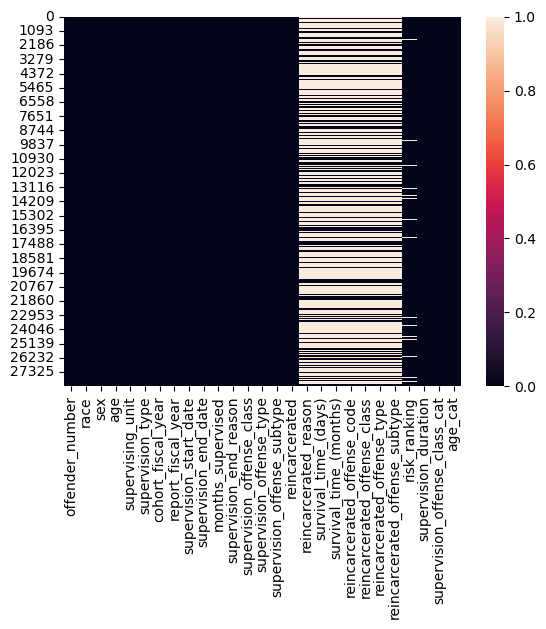

In [17]:
sns.heatmap(iowa_df.isnull())

In [18]:
#Should probably look at any trends in this subpop befor dropping...? 
iowa_df[iowa_df['risk_ranking'].isnull()]

,offender_number,race,sex,age,supervising_unit,supervision_type,cohort_fiscal_year,report_fiscal_year,supervision_start_date,supervision_end_date,...,survival_time_(days),survival_time_(months),reincarcerated_offense_code,reincarcerated_offense_class,reincarcerated_offense_type,reincarcerated_offense_subtype,risk_ranking,supervision_duration,supervision_offense_class_cat,age_cat
0,20655350,White,Male,35,Newton Correctional Facility,Prison,2018-01-01,2021-01-01,2007-12-07,2018-05-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3826,Felony,middle
1,18876932,Black,Male,30,Mount Pleasant Correctional Facility,Prison,2017-01-01,2020-01-01,2012-11-08,2016-12-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503,Felony,middle
2,2424146,White,Male,40,Iowa Medical & Classification Center,Prison,2016-01-01,2019-01-01,2015-04-21,2015-12-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247,Misdemeanor,middle
3,19088303,Black,Male,29,Fort Dodge Correctional Facility,Work Release,2016-01-01,2019-01-01,2015-07-20,2015-10-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88,Felony,middle
4,20280797,White,Male,38,Districts/Compact Regions,Prison,2016-01-01,2019-01-01,2015-06-08,2016-05-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,358,Misdemeanor,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28382,20971085,White,Male,37,Newton Correctional Facility,Prison,2021-01-01,2024-01-01,2018-04-09,2021-03-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1078,Felony,middle
28383,20972534,White,Male,50,Fort Dodge Correctional Facility,Prison,2021-01-01,2024-01-01,2016-08-17,2020-10-09,...,594.0,19.8,908.5(2)B,D Felony,Other,Other Criminal,NaN,1514,Felony,over 45
28388,20975984,White,Male,56,Newton Correctional Facility,Prison,2021-01-01,2024-01-01,2018-01-22,2021-06-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1242,Felony,over 45
28403,20983460,White,Male,31,Newton Correctional Facility,Prison,2021-01-01,2024-01-01,2017-07-20,2020-10-13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1181,Felony,middle


## 2. Exploratory Data Analysis

### 2.1 Other Explorations

In [19]:
#To look at: what racial groups get charged for what, etc

In [20]:
race_grouped = iowa_df.groupby("race").size().to_frame().rename(columns={0:"count"}).reset_index() #.sort_values("count", ascending=False)
#Create a bar chart showing the counts or proportions of each racial category.
bar_race = px.bar(race_grouped, x="race", y="count", title="Number of Incarcerated Individuals per Represented Race", labels ='race', width=600, height=400)
bar_race.show()

In [21]:
race_grouped

,race,count
0,American Indian or Alaska Native,585
1,Asian or Pacific Islander,220
2,Black,6066
3,Hispanic,1621
4,Unknown,6
5,White,19918


In [22]:
sex_grouped = iowa_df.groupby("sex").size().to_frame().rename(columns={0:"count"}).reset_index() #.sort_values("count", ascending=False)
#Create a bar chart showing the counts or proportions of each sex category.
bar_sex = px.bar(sex_grouped, x="sex", y="count", title="Number of Incarcerated Individuals per Represented Sex", labels ='sex', width=600, height=400)
bar_sex.update_traces(width=.2)
bar_sex.show()

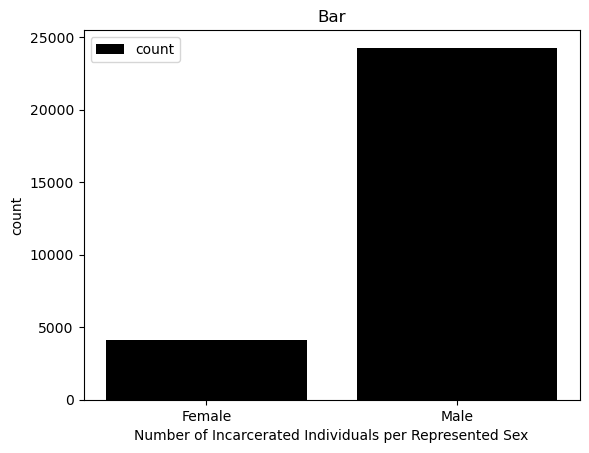

In [23]:
plt.bar(sex_grouped['sex'], sex_grouped['count'],label="count",color="black")

plt.xlabel("Number of Incarcerated Individuals per Represented Sex")
plt.ylabel("count")
plt.title("Bar")
plt.legend()
plt.show()

In [24]:
type_grouped = iowa_df.groupby("supervision_offense_type").size().to_frame().rename(columns={0:"count"}).reset_index() #.sort_values("count", ascending=False)
#Create a bar chart showing the counts or proportions of each sex category.
bar_type = px.bar(type_grouped, x="supervision_offense_type", y="count", title="Offense Type Breakdown", labels ='offense type', width=600, height=400)
bar_type.show()

<Axes: >

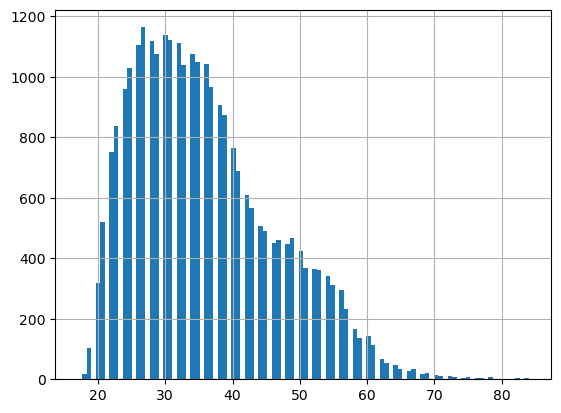

In [25]:
iowa_df['age'].hist(bins=100)

In [26]:
race_grouped['percent'] = (round((race_grouped['count'] / np.sum(race_grouped['count'])) , 3)) * 100
race_grouped.head(10)

,race,count,percent
0,American Indian or Alaska Native,585,2.1
1,Asian or Pacific Islander,220,0.8
2,Black,6066,21.3
3,Hispanic,1621,5.7
4,Unknown,6,0.0
5,White,19918,70.1


In [27]:
for racestring in iowa_df['race'].unique():
    iowa_df[iowa_df['race'] == racestring].groupby('risk_ranking').size().to_frame().rename(columns={0:"count"}).reset_index()

blackall_df = iowa_df[iowa_df['race'] == 'Black'].groupby('risk_ranking').size().to_frame().rename(columns={0:"count"}).reset_index()
blackall_df

,risk_ranking,count
0,High,3707
1,Low,1201
2,Moderate,964


In [28]:
# proportions. i am obsessed w the groupby function. 
risk_counts = iowa_df.groupby(['race', 'risk_ranking']).size().unstack(fill_value=0)

# risk score percentages, rounding 
risk_percentages = round((risk_counts.div(risk_counts.sum(axis=1), axis=0) * 100), 2)
risk_percentages = risk_percentages.rename(columns={'high': 'high_percent', 'moderate': 'moderate_percent', 'low': 'low_percent'})

# reincarceration percentages and rounding 
reincarceration_rates = round((iowa_df.groupby('race')['reincarcerated'].mean() * 100), 2)
reincarceration_rates = reincarceration_rates.rename('reincarceration_percent')

result = risk_percentages.join(reincarceration_rates).reset_index()

result


,race,High,Low,Moderate,reincarceration_percent
0,American Indian or Alaska Native,50.00,35.09,14.91,45.13
1,Asian or Pacific Islander,36.54,43.27,20.19,32.73
2,Black,63.13,20.45,16.42,35.82
3,Hispanic,51.77,33.40,14.83,30.72
4,White,46.25,37.75,16.00,38.22


In [29]:
risk_counts

risk_ranking,High,Low,Moderate
race,,,
American Indian or Alaska Native,285,200,85
Asian or Pacific Islander,76,90,42
Black,3707,1201,964
Hispanic,775,500,222
White,8762,7153,3031


In [30]:
iowa_df[iowa_df['race'] == 'Black'].groupby('risk_ranking').size()

risk_ranking
High        3707
Low         1201
Moderate     964
dtype: int64

In [31]:
iowa_df['race'].unique()

array(['White', 'Black', 'Hispanic', 'Asian or Pacific Islander',
       'American Indian or Alaska Native', 'Unknown'], dtype=object)

### 2.2 Linear Regression

In [32]:
iowacats_df = iowa_df.loc[iowa_df['race'] != 'Unknown'] 
score_dict = {
    'High': ['High'],
    'Low': ['Low', 'Moderate'] 
}
categorize_sort(iowacats_df, 'risk_ranking', score_dict)

iowacats_df['crime_factor'] = iowacats_df['supervision_offense_class_cat'].astype('category')

# Relevel age_factor to have reference level at index 1
iowacats_df['age_factor'] = iowacats_df['age_cat'].astype('category')
#iowacats_df['age_factor'] = iowacats_df['age_factor'].cat.reorder_categories(iowacats_df['age_factor'].cat.categories, ordered=True)

# Relevel race_factor to have reference level at index 3
iowacats_df['race_factor'] = iowacats_df['race'].astype('category')
#iowacats_df['race_factor'] = iowacats_df['race_factor'].cat.reorder_categories(iowacats_df['race_factor'].cat.categories, ordered=True)

# Relevel gender_factor to have reference level at index 2
iowacats_df['gender_factor'] = iowacats_df['sex'].astype('category').cat.rename_categories(["Female", "Male"])
#iowacats_df['gender_factor'] = iowacats_df['gender_factor'].cat.reorder_categories(iowacats_df['gender_factor'].cat.categories, ordered=True)

iowacats_df['score_factor'] = (iowacats_df['risk_ranking_cat'] == "High").astype(int)

# Fit the linear regression model
model = smf.glm("score_factor ~ gender_factor + age_factor + race_factor + crime_factor ",
                data=iowacats_df, family=sm.families.Binomial()).fit()

# Display model summary 
print(model.summary())


C:\Users\rubyc\AppData\Local\Temp\ipykernel_30800\181015187.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rubyc\AppData\Local\Temp\ipykernel_30800\998286548.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rubyc\AppData\Local\Temp\ipykernel_30800\998286548.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

                 Generalized Linear Model Regression Results                  
Dep. Variable:           score_factor   No. Observations:                28405
Model:                            GLM   Df Residuals:                    28396
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18469.
Date:                Wed, 26 Feb 2025   Deviance:                       36939.
Time:                        11:09:15   Pearson chi2:                 2.84e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08064
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [33]:
#black ppl compared to all
control = np.exp(-0.3843 ) / (1 + np.exp(-0.3843))
result = np.exp(0.2811 ) / (1 - control + (control * np.exp(0.2811)))
result

1.1706599237321942

In [34]:
#men less than half as likely to get a "high" score 
np.exp(1.1745) / (1 - control + (control * np.exp(1.1745)))

1.69807676627299

### 2.3 One-Hot Encoding for Classification Models

In [35]:
#drop rows where they weren't released 
#iowaclean_df = iowa_df[iowa_df.reincarcerated]

#dropping leakage features, time features bc they cannot be encoded, and ones that would explore the feature dimentionality 
leakage_drop_l = ['supervision_end_date', 'months_supervised', 'supervision_end_reason', 'reincarcerated','reincarcerated_offense_subtype', 'reincarcerated_offense_type', 'reincarcerated_offense_class', 
              'reincarcerated_offense_code', 'survival_time_(months)','survival_time_(days)', 'reincarcerated_reason']
              
other_drop_l = ['cohort_fiscal_year', 'report_fiscal_year','supervision_start_date','supervision_end_date','supervision_offense_subtype', 'supervising_unit']

In [36]:
iowaclean_df = iowa_df.drop(leakage_drop_l + other_drop_l, axis=1)

# Define features and target
X = iowaclean_df.drop(columns=['risk_ranking', 'offender_number'])  # Drop ID columns
y = iowaclean_df['risk_ranking']

# Encode categorical target variable (if not numeric)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define transformers
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Apply transformations
X = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# split the data with 0.20 proportion for test size
# train_test_split returns 4 values: X_train, X_test, y_train, y_test 
X, X_test, y, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42, stratify=y)
# split the remaining data with 0.75 proportion for train size and 0.25 for validation size
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42, stratify=y)

In [37]:
iowa_df.groupby('risk_ranking').count()
(13605 + 9144) / len(iowa_df)

0.8005701013513513

### 2.5 Classification Models

In [ ]:
def class_modeller(classifier, graph=False, title=""):
    """
    A function that takes in a model, trains it, then returns schtuff
    ----------
    classifier: the  model to be fitted
    graph: Optionally plots a graph of actual vs predicted values, default = F
    """
    model = classifier.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_train = model.predict(X_train)

    #conf_matrix = confusion_matrix(y_test, pred)
    #class_report = classification_report(y_test, pred)

    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred)

    train_precision = precision_score(y_train, pred_train, average='macro')
    test_precision = precision_score(y_test, pred, average='macro')
    
    train_recall = recall_score(y_train, pred_train, average='macro')
    test_recall = recall_score(y_test, pred, average='macro')
    
    train_f1 = f1_score(y_train, pred_train, average='macro')
    test_f1 = f1_score(y_test, pred, average='macro')
    
    # # For multi-class classification, predict_proba provides probabilities for each class
    # try:
    #     # Only apply roc_auc_score if the model supports probability prediction (predict_proba)
    #     train_aucroc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr', average='macro')
    #     test_aucroc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='macro')
    # except AttributeError:
    #     # If the model doesn't support predict_proba, set AUC to NaN or another value
    #     train_aucroc = test_aucroc = None
    
    if graph==True:
        plt.scatter(y_test, pred)
        plt.xlabel('actual value')
        plt.ylabel('predicted value')
        plt.plot(y_test, y_test, color = 'red', label = 'x=y')
        plt.title('Residual Plot '+title)
        plt.legend()
        plt.show()
    return [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall, train_f1, test_f1] #confusion_matrix, classification_report
#train_aucroc, test_aucroc

In [ ]:
#yikes
class_models = [
    LogisticRegression(max_iter = 1000),
    RandomForestClassifier(class_weight='balanced', random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    SVC(kernel='linear', probability=True),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

]
# add svm 
#logistic regression for dichotomous outcomes 

class_model_accs = pd.DataFrame([class_modeller(model) for model in class_models],
            columns = [ #'confusion_matrix', 'classification_report', 
                       'train_accuracy', 'test_accuracy', 
                       'train_precision', 'test_precision',
                       'train_recall', 'test_recall',
                       'train_f1', 'test_f1',],
            index = ['LogisticRegression','RandomForestClassifier','GradientBoostingClassifier', 'XGBClassifier','SVC', 'MLPClassifier'])
#sort based on Test R2
class_model_accs.sort_values('test_f1', ascending=False)


c:\Users\rubyc\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[12:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1
XGBClassifier,0.697050,0.594476,0.754692,0.512955,0.604070,0.480914,0.618083,0.471816
MLPClassifier,0.621737,0.599930,0.601878,0.509462,0.509269,0.484182,0.503171,0.469158
GradientBoostingClassifier,0.614640,0.602041,0.675452,0.500719,0.497367,0.473860,0.484145,0.459784
RandomForestClassifier,0.993900,0.537298,0.991450,0.464425,0.995844,0.453502,0.993625,0.456278
LogisticRegression,0.587483,0.584448,0.573577,0.460084,0.426531,0.420658,0.424647,0.417469
SVC,0.585020,0.581281,0.525350,0.450181,0.421133,0.412192,0.417963,0.406992


In [ ]:
#yikes
class_models_tuned = [
    LogisticRegression(C = 0.01, penalty = 'l1', solver = 'liblinear', max_iter = 1000),
    RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42, max_depth=None, min_samples_split=2),
    GradientBoostingClassifier(n_estimators=100, random_state=42, learning_rate=0.01, max_depth=3, subsample=0.8),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', colsample_bytree = 0.8, learning_rate = 0.01, max_depth = 3, n_estimators = 100, subsample = 0.8),
    SVC(kernel='linear', probability=True, C = 0.1, gamma = 'scale'),
    MLPClassifier(alpha = 0.0001, hidden_layer_sizes=(50,), max_iter=500, random_state=42, learning_rate = 'constant')

]
# add svm 
#logistic regression for dichotomous outcomes 

class_model_tuned_accs = pd.DataFrame([class_modeller(model) for model in class_models_tuned],
            columns = [ #'confusion_matrix', 'classification_report', 
                       'train_accuracy', 'test_accuracy', 
                       'train_precision', 'test_precision',
                       'train_recall', 'test_recall',
                       'train_f1', 'test_f1',],
            index = ['LogisticRegression','RandomForestClassifier','GradientBoostingClassifier', 'XGBClassifier','SVC', 'MLPClassifier'])
#sort based on Test R2
class_model_tuned_accs.sort_values('test_f1', ascending=False)


c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\U

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1
RandomForestClassifier,0.998431,0.552731,0.998110,0.453062,0.999066,0.424260,0.998586,0.433448
MLPClassifier,0.651444,0.599812,0.617240,0.472199,0.512630,0.439669,0.512025,0.430924
XGBClassifier,0.614093,0.609228,0.498077,0.496445,0.411504,0.394037,0.420869,0.402629
GradientBoostingClassifier,0.604049,0.596987,0.510113,0.509875,0.390927,0.373271,0.397547,0.378152
SVC,0.583490,0.589454,0.464404,0.456732,0.362757,0.353500,0.363286,0.350811
LogisticRegression,0.589768,0.589925,0.433985,0.410862,0.323013,0.322587,0.308728,0.307132


Feeling not great about these models - all low test f1 scores and it feels like I'm just throwing a bunch of models at it and seeing if anything sticks...

#### Hyperparameter tuning

In [ ]:
#
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]



Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
logreg_params = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga']  # Needed for L1 regularization
}

grid_logreg = GridSearchCV(LogisticRegression(max_iter=1000), logreg_params, cv=5, scoring='f1', n_jobs=-1)
grid_logreg.fit(X_train, y_train)

print("Best Parameters for Logistic Regression:", grid_logreg.best_params_)


Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]



In [ ]:
gbm_params = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Step size
    'max_depth': [3, 5, 7],  # Tree depth
    'subsample': [0.8, 1.0],  # Fraction of samples per boosting round
}

grid_gbm = GridSearchCV(GradientBoostingClassifier(), gbm_params, cv=5, scoring='f1', n_jobs=-1)
grid_gbm.fit(X_train, y_train)

print("Best Parameters for Gradient Boosting:", grid_gbm.best_params_)

c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]



Best Parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],  # Feature sampling
}

grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_params, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best Parameters for XGBoost:", grid_xgb.best_params_)


c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]

c:\Users\rubyc\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[21:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
svc_params = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'rbf'],  # Linear or RBF kernel
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

grid_svc = GridSearchCV(SVC(), svc_params, cv=5, scoring='f1', n_jobs=-1)
grid_svc.fit(X_train, y_train)

print("Best Parameters for SVC:", grid_svc.best_params_)


c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]



Best Parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],  # Number of neurons
    'alpha': [0.0001, 0.01, 0.1],  # L2 regularization
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
}

grid_mlp = GridSearchCV(MLPClassifier(max_iter=500), mlp_params, cv=5, scoring='f1', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

print("Best Parameters for MLP:", grid_mlp.best_params_)


c:\Users\rubyc\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]



Best Parameters for MLP: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}


### 2.6 Chi-Square independence; Correlation Matrix

In [38]:
cat_cols = list(iowa_df.select_dtypes(include=['object']).columns)

for col in cat_cols:
    contingency_table = pd.crosstab(index=iowa_df[col], columns='count')
    print(f"Contingency Table for {col}:")
    print(contingency_table)
    print("\n")

Contingency Table for race:
col_0                             count
race                                   
American Indian or Alaska Native    585
Asian or Pacific Islander           220
Black                              6066
Hispanic                           1621
Unknown                               6
White                             19918


Contingency Table for sex:
col_0   count
sex          
Female   4135
Male    24278


Contingency Table for supervising_unit:
col_0                                    count
supervising_unit                              
Anamosa State Penitentiary                1139
Clarinda Correctional Facility            2808
Detained by Non-Iowa                        11
Districts/Compact Regions                 1017
Fort Dodge Correctional Facility          3733
Iowa Correctional Institution for Women   3971
Iowa Medical & Classification Center      3884
Iowa State Penitentiary                    557
Mount Pleasant Correctional Facility      4520
Newton C

In [39]:
iowa_df.columns

Index(['offender_number', 'race', 'sex', 'age', 'supervising_unit',
       'supervision_type', 'cohort_fiscal_year', 'report_fiscal_year',
       'supervision_start_date', 'supervision_end_date', 'months_supervised',
       'supervision_end_reason', 'supervision_offense_class',
       'supervision_offense_type', 'supervision_offense_subtype',
       'reincarcerated', 'reincarcerated_reason', 'survival_time_(days)',
       'survival_time_(months)', 'reincarcerated_offense_code',
       'reincarcerated_offense_class', 'reincarcerated_offense_type',
       'reincarcerated_offense_subtype', 'risk_ranking',
       'supervision_duration', 'supervision_offense_class_cat', 'age_cat'],
      dtype='object')

In [40]:
contingency_drop = ['cohort_fiscal_year', 
                    'report_fiscal_year',
                    'supervision_start_date',
                    'supervision_end_date',
                    'supervision_offense_subtype', 
                    'supervising_unit', 
                    'reincarcerated_offense_subtype',
                    'reincarcerated_offense_code', 
                    'survival_time_(months)',
                    'survival_time_(days)',
                    'supervision_end_date', 
                    'months_supervised',
                    'offender_number',
                    'age',
                    'supervision_duration',
                    'supervision_end_reason',
                    'reincarcerated',
                    'reincarcerated_reason',
                    'reincarcerated_offense_type']
iowaclean2_df = iowa_df.drop(contingency_drop, axis=1)
onehot_df = pd.get_dummies(data = iowaclean2_df, columns = iowaclean2_df.columns, drop_first = True).dropna()
onehot_df

,race_Asian or Pacific Islander,race_Black,race_Hispanic,race_Unknown,race_White,sex_Male,supervision_type_Work Release,supervision_offense_class_Aggravated Misdemeanor,supervision_offense_class_B Felony,supervision_offense_class_C Felony,...,reincarcerated_offense_class_Felony - Mandatory Minimum,reincarcerated_offense_class_Other Felony,reincarcerated_offense_class_Serious Misdemeanor,reincarcerated_offense_class_Simple Misdemeanor,reincarcerated_offense_class_Special Sentence 2005,risk_ranking_Low,risk_ranking_Moderate,supervision_offense_class_cat_Misdemeanor,age_cat_middle,age_cat_over 45
0,False,False,False,False,True,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,True,True,False,True,False,False,...,False,False,False,False,False,False,False,True,True,False
3,False,True,False,False,False,True,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,True,True,False,True,False,False,...,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28411,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28412,False,False,False,False,True,True,True,False,True,False,...,False,False,False,False,False,False,True,False,True,False
28413,False,False,False,False,True,True,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
28414,False,False,False,False,True,True,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False


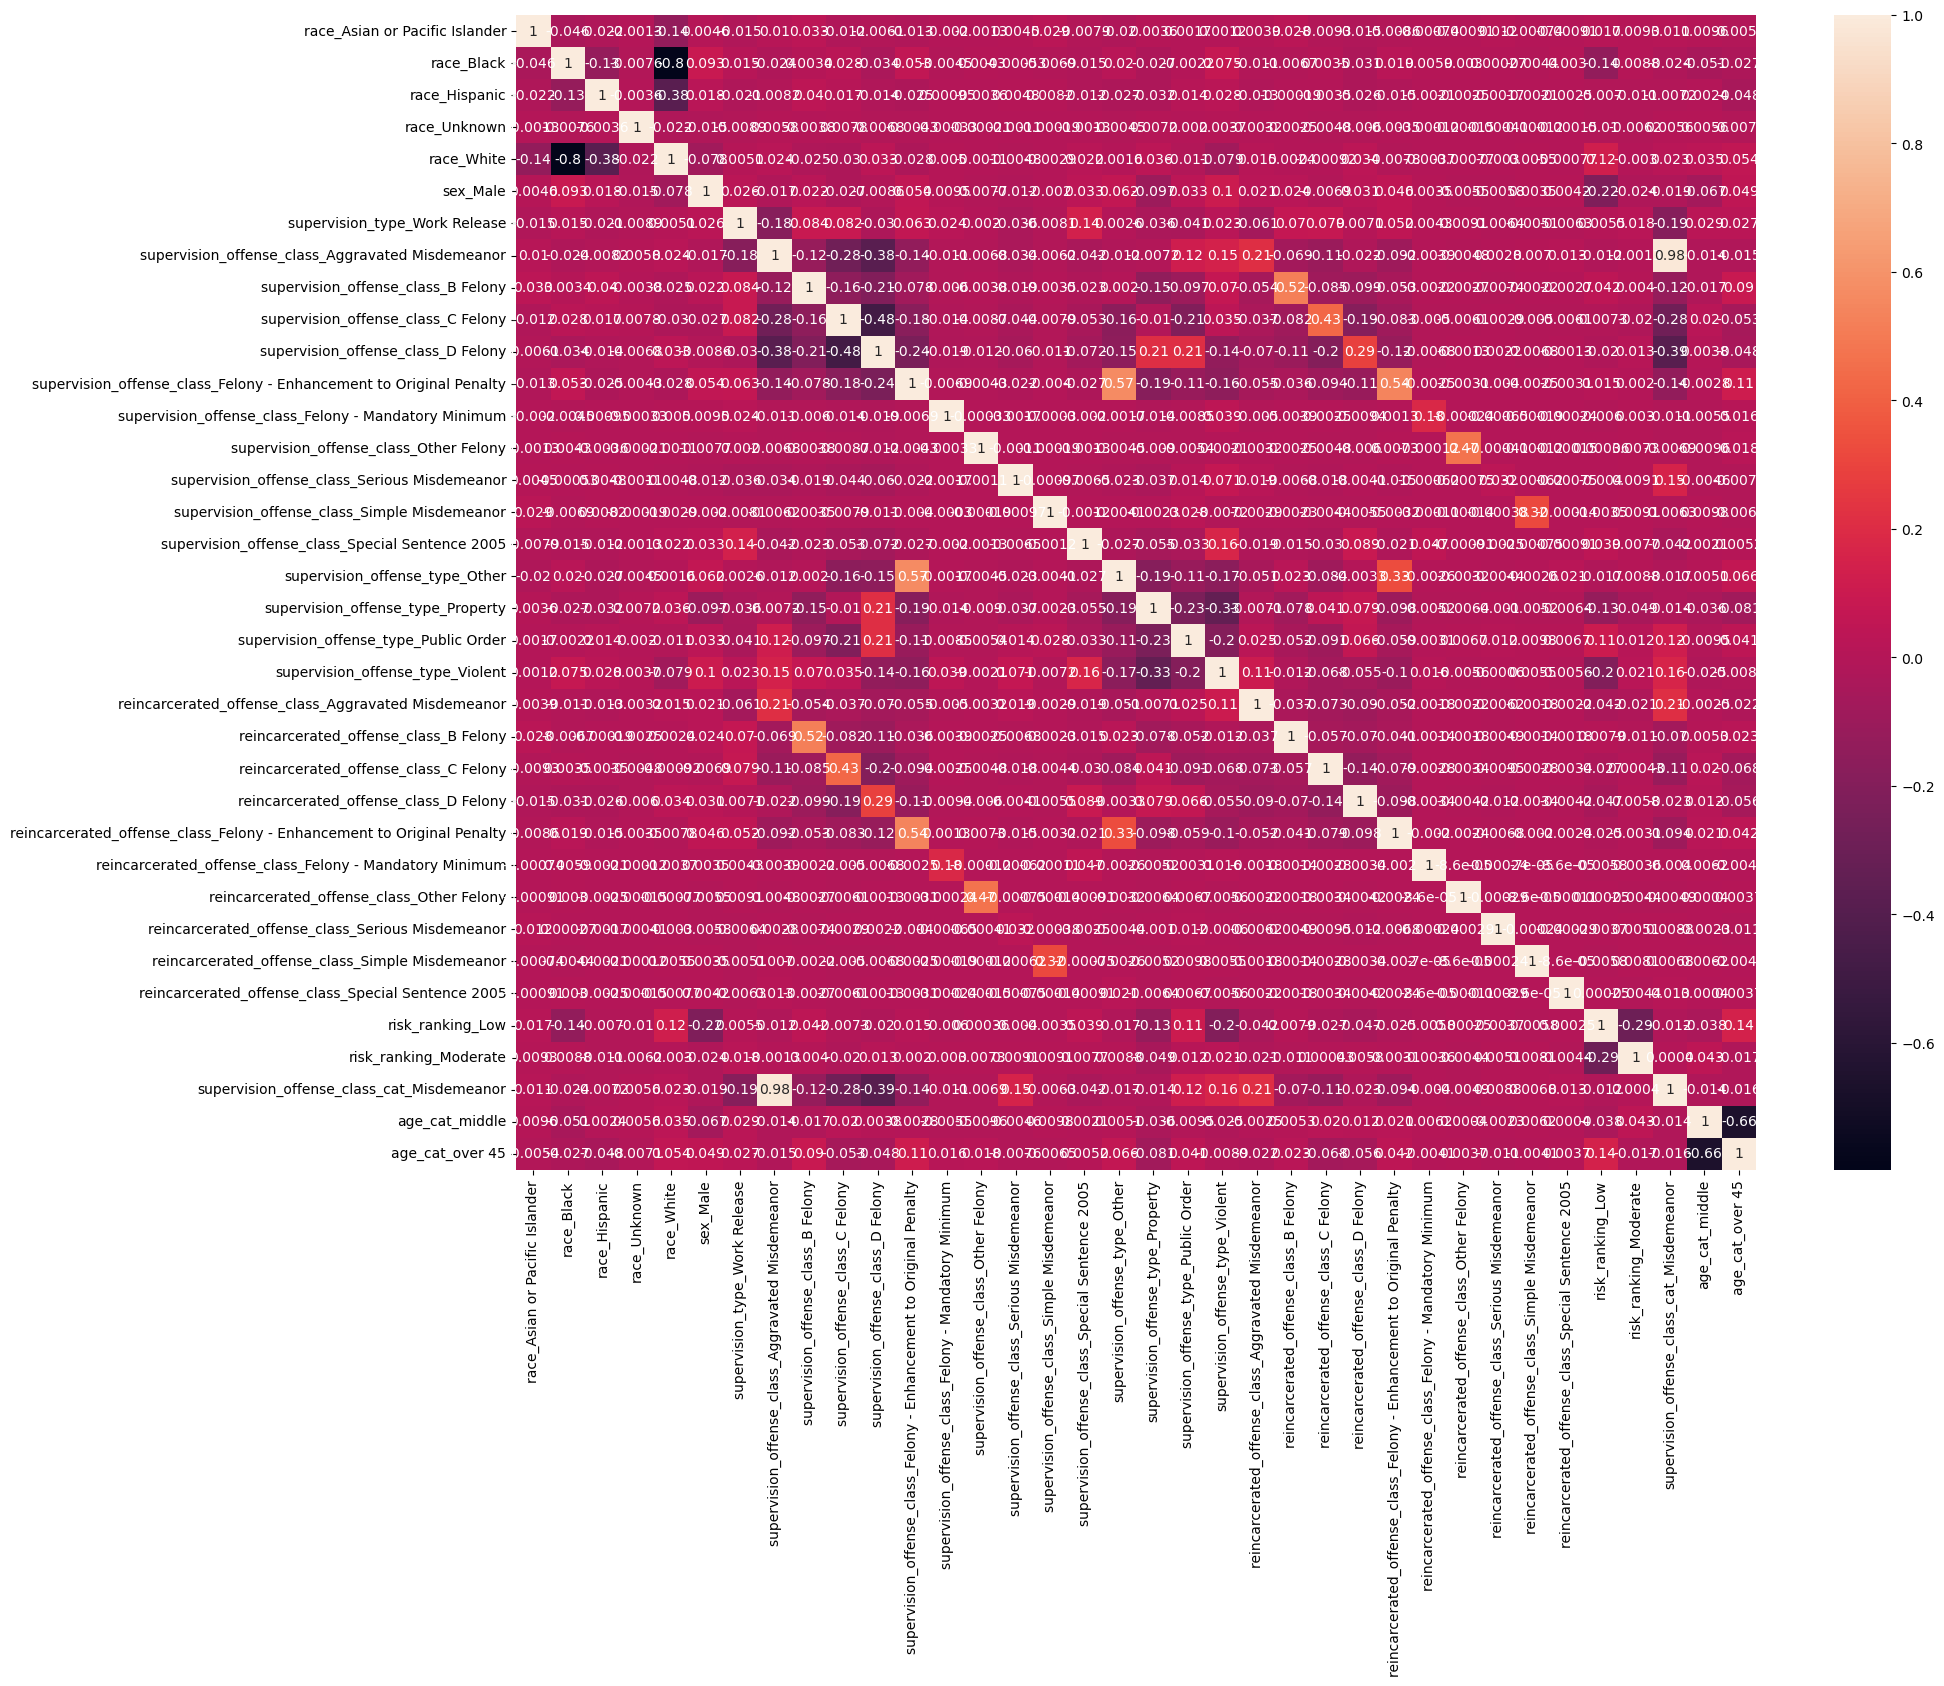

In [41]:
#iowa_df['race']=iowa_df['race'].astype('category').cat.codes
corrmatrix = onehot_df.corr()
plt.figure(figsize=(20,15))
g = sns.heatmap(corrmatrix, annot=True)

In [42]:
#Chi-Squares Independance
crosstab = pd.crosstab(iowa_df['risk_ranking'], iowa_df['race'])
crosstab

race,American Indian or Alaska Native,Asian or Pacific Islander,Black,Hispanic,White
risk_ranking,,,,,
High,285,76,3707,775,8762
Low,200,90,1201,500,7153
Moderate,85,42,964,222,3031


In [43]:
stats.chi2_contingency(crosstab)

Chi2ContingencyResult(statistic=671.1040117921284, pvalue=1.1874963210505907e-139, dof=8, expected_freq=array([[ 286.23076071,  104.4491197 , 2948.67899457,  751.73236629,
        9513.90875872],
       [ 192.37736685,   70.20086369, 1981.82438268,  505.24371609,
        6394.35367069],
       [  91.39187244,   33.35001661,  941.49662274,  240.02391762,
        3037.73757059]]))

The first value (671.1) is the Chi-square value, followed by the p-value (4.29e-139), then comes the degrees of freedom (8), and lastly it outputs the expected frequencies as an array. Since all of the expected frequencies are greater than 5, the chi2 test results can be trusted. We can reject the null hypothesis as the p-value is less than 0.05. Thus, the results indicate that there is a relationship between race and recidivism prediction score. https://pythonfordatascienceorg.wordpress.com/chi-square-python/

In [44]:
chionehot_df = pd.get_dummies(iowa_df['risk_ranking'])

In [45]:
for s in chionehot_df:
    nl = "\n"
    
    crosstab = pd.crosstab(chionehot_df[f"{s}"], iowa_df['race'])
    print(crosstab, nl)
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")

race   American Indian or Alaska Native  Asian or Pacific Islander  Black  \
High                                                                        
False                               300                        144   2359   
True                                285                         76   3707   

race   Hispanic  Unknown  White  
High                             
False       846        6  11156  
True        775        0   8762   

Chi2 value= 567.6484669115247
p-value= 1.9721175187970842e-120
Degrees of freedom= 5

race   American Indian or Alaska Native  Asian or Pacific Islander  Black  \
Low                                                                         
False                               385                        130   4865   
True                                200                         90   1201   

race   Hispanic  Unknown  White  
Low                              
False      1121        6  12765  
True        500        0   7153   

Chi2 value= 566.1364

In [46]:
iowa_df['risk_ranking'].unique()

array([nan, 'High', 'Low', 'Moderate'], dtype=object)

In [47]:
iowaclean2_df = iowaclean2_df.dropna(subset='risk_ranking')
# Define features and target
X = iowaclean2_df.drop(columns=['risk_ranking'])  # Drop ID columns
y = iowaclean2_df['risk_ranking']

# Encode categorical target variable (if not numeric)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define transformers
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Apply transformations
X = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# split the data with 0.20 proportion for test size
# train_test_split returns 4 values: X_train, X_test, y_train, y_test 
X, X_test, y, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42, stratify=y)
# split the remaining data with 0.75 proportion for train size and 0.25 for validation size
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42, stratify=y)

In [48]:
svm = svm.LinearSVC()
svm_model = svm.fit(X_train, y_train)
svm_pred = svm_model.predict(X_val)
np.mean(svm_pred == y_val)
svm_cf_matrix = confusion_matrix(y_val, svm_pred)


c:\Users\rubyc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



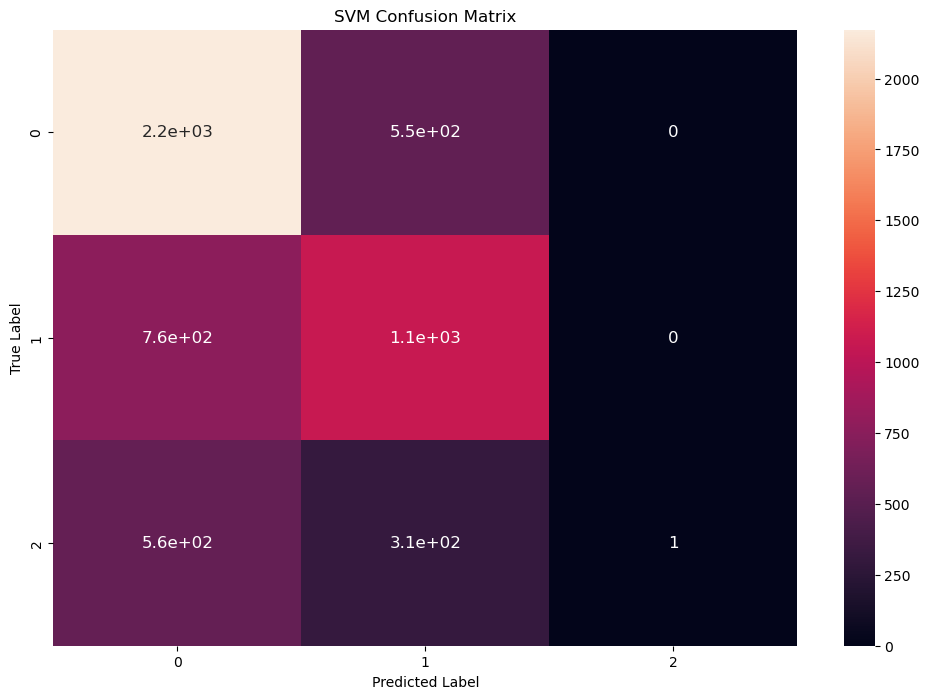

In [49]:
svm_df_cm = pd.DataFrame(svm_cf_matrix, range(3),
                  range(3))

#svm_df_cm = svm_df_cm.rename(index=str, columns={0: "python", 1: "xml", 2: "java", 3: "json"})
#svm_df_cm.index = ['python', 'xml', 'java', 'json']
plt.figure(figsize = (12,8))
#sns.set(font_scale=1.2)#for label size
sns.heatmap(svm_df_cm, 
           annot=True,
           annot_kws={"size": 12})

plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [50]:
svm_df_cm

,0,1,2
0,2172,549,0
1,764,1065,0
2,560,308,1


This... is so oddddd

### 2.6 Decision Tree

In [51]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [52]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5993725779664145


In [53]:
# define the method
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=3)
# fit the model
rfe.fit(X, y)
# transform the data
X, y = rfe.transform(X, y)

TypeError: SelectorMixin.transform() takes 2 positional arguments but 3 were given

In [ ]:
counts = iowa_df['Race'].value_counts()
counts_df = counts.to_frame().reset_index()
counts_df

,Race,count
0,White,19918
1,Black,6066
2,Hispanic,1621
3,American Indian or Alaska Native,585
4,Asian or Pacific Islander,220
5,Unknown,6


## 3. Modeling

In [54]:
iowamod_df = iowa_df[iowa_df.reincarcerated].dropna(subset = 'risk_ranking')
T = iowamod_df['risk_ranking']
E = iowamod_df['survival_time_(days)']

label_encoder = preprocessing.LabelEncoder()
iowamod_df['risk_ranking_encoded']= label_encoder.fit_transform(iowamod_df['risk_ranking'])
#encoder = LabelEncoder()
#iowamod_df['race_encoded'] = encoder.fit_transform(iowamod_df['race'])
iowamod_df

,offender_number,race,sex,age,supervising_unit,supervision_type,cohort_fiscal_year,report_fiscal_year,supervision_start_date,supervision_end_date,...,survival_time_(months),reincarcerated_offense_code,reincarcerated_offense_class,reincarcerated_offense_type,reincarcerated_offense_subtype,risk_ranking,supervision_duration,supervision_offense_class_cat,age_cat,risk_ranking_encoded
26,154115,White,Male,53,Iowa Medical & Classification Center,Prison,2018-01-01,2021-01-01,2015-08-31,2018-03-20,...,6.8,124.401(1)(b)(7),B Felony,Drug,Trafficking,High,932,Felony,over 45,0
64,3115148,White,Male,44,Newton Correctional Facility,Work Release,2018-01-01,2021-01-01,2017-08-17,2017-11-17,...,14.2,124.401(1)(c)(6),C Felony,Drug,Trafficking,Low,92,Felony,middle,1
68,3174044,White,Male,52,Newton Correctional Facility,Prison,2018-01-01,2021-01-01,2017-08-16,2018-04-16,...,10.3,124.401(5)(c),D Felony,Drug,Drug Possession,Low,243,Felony,over 45,1
79,3196022,White,Male,44,Newton Correctional Facility,Work Release,2018-01-01,2021-01-01,2017-10-06,2018-04-03,...,21.1,124.401(1)(b)(7),B Felony,Drug,Trafficking,Low,179,Felony,middle,1
85,2406020,Black,Male,54,Newton Correctional Facility,Prison,2019-01-01,2022-01-01,2018-05-25,2019-01-23,...,26.8,124.401(1)(c)(6),C Felony,Drug,Trafficking,Low,243,Felony,over 45,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28402,20983109,White,Male,37,Fort Dodge Correctional Facility,Prison,2021-01-01,2024-01-01,2019-11-18,2020-11-30,...,30.8,"902.8,B",Felony - Enhancement to Original Penalty,Other,Other Criminal,Low,378,Felony,middle,1
28404,20985365,White,Female,30,Iowa Correctional Institution for Women,Prison,2021-01-01,2024-01-01,2020-03-31,2020-12-03,...,29.7,124.401(5)(c),D Felony,Drug,Drug Possession,Low,247,Felony,middle,1
28405,20986826,White,Male,31,Mount Pleasant Correctional Facility,Prison,2021-01-01,2024-01-01,2019-08-02,2021-02-26,...,25.3,708.2A(4),D Felony,Violent,Assault,High,574,Felony,middle,0
28412,20998529,White,Male,40,Mount Pleasant Correctional Facility,Work Release,2021-01-01,2024-01-01,2020-04-09,2020-08-14,...,2.7,124.401(1)(b)(7),B Felony,Drug,Trafficking,Moderate,127,Felony,middle,2


In [55]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

c:\Users\rubyc\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1185: UserWarning:

Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.



TypeError: Wrong dtype 'object'.

KeyError: 'race_encoded'

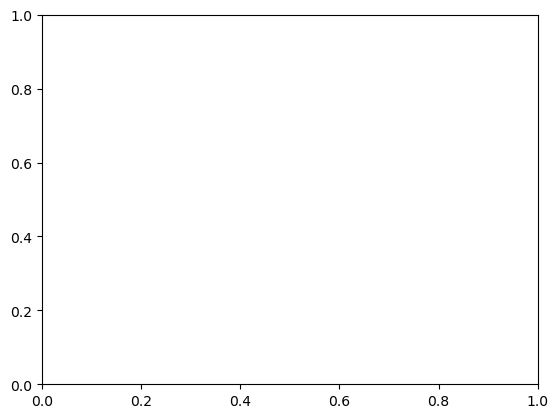

In [56]:
ax = plt.subplot(111)
m = (iowamod_df['race_encoded'] == 4)
kmf.fit(durations = T[m], event_observed = E[m], label = 0)
kmf.plot_survival_function(ax = ax)
kmf.fit(T[~m], event_observed = E[~m], label = 1)
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival of different racial group")